# Load data

## A

***Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in theoriginal training set***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

file_path = "/content/drive/MyDrive/ASI/Progetto/santander_dataset"

df = pd.read_csv(f'{file_path}/train.csv')

test_size = 0.5

X_train, X_test, y_train, y_test = train_test_split(df[df.columns.drop("target")], 
                                                    df["target"], test_size=test_size, 
                                                    random_state=42)


X_train = X_train.iloc[:,1:]
X_test = X_test.iloc[:,1:]

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Percentage of positive records: 0.10
Percentage of negative records: 0.90
Number of features: 200


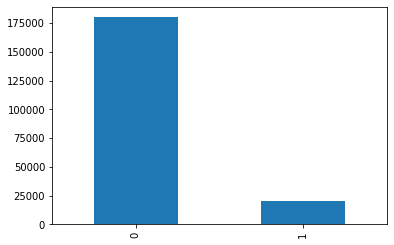

In [ ]:
pd.value_counts(df['target']).plot.bar()

print(f"Percentage of positive records: {(df['target'] == 1).sum() / (df.shape[0]):.2f}")
print(f"Percentage of negative records: {(df['target'] == 0).sum() / (df.shape[0]):.2f}")


print(f"Number of features: {X_train.shape[1]}")

## B

***Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.***

### Class distribution

The dataset is imbalanced: $90\%$ of the records are negative, whereas only $10\%$ are positive. As a consequence certain type of metrics, such as accuracy, will not be useful, since even a dummy model that predicts only $0$ will have an high accuracy, while not recognizing even a record of class $1$.

### Dimensionality

The input has an high dimensionality: each records has $200$ numerical features. 

In a multivariate regression model, as the number of predictors $p$ increases for a given sample size $n$, observations become much more sparsely distributed across the domain of the predictors and hence there are typically subregions of $X$ having few observations. This issue is often referred as Curse of Dimensionality

Another issue is that the inversion of matrix in high-dimension is computionally very expensive: $O(D^3)$

# 1) Bayesian Linear Regression

## 1.A

***Implement Bayesian linear regression (you should already have an implementa-
tion from the lab sessions)***

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

def lognormal(x, mu, var):
    return np.log(1/(np.sqrt(var*2*math.pi))) - (1/2)*((x-mu)**2)/var

def gaussian_loglik(y, y_tilde, sn2):
    # @@ COMPLETE @@ #
    return np.sum(lognormal(y_tilde, y, sn2))


def plot_gaussian(mu, var, plot_log=False, **kwargs):
    """A simple util to plot a gaussian pdf"""
    x = np.linspace(mu - 5 * np.sqrt(var), mu + 5 * np.sqrt(var), 200)
    y = lognormal(x, mu, var) if plot_log else np.exp(lognormal(x, mu, var))
    ax = kwargs.pop("ax", plt.gca())
    ax.plot(x, y, **kwargs)
    return ax


def add_bias(x):
    X = np.column_stack([np.ones(x.shape[0]) ,x])
    
    return X

def cholesky_inverse(A):

  # A = L * L.T
  L = np.linalg.cholesky(A)

  n = A.shape[0]

  # A * A_inv = I
  # L * L.T * A_inv = I
  # L * x = I
  # (x = L.T * A_inv)
  x = np.linalg.solve(L, np.eye(n))

  # L.T * A_inv = x
  A_inv = np.linalg.solve(L.T, x)
  
  return A_inv

def compute_posterior(X, y, sw2, sn2):
    # @@ COMPLETE @@ #

    S = sw2 * np.identity(X.shape[1])

    sigma_inverse = (1/sn2)*(X.T @ X + cholesky_inverse(S))

    sigma = cholesky_inverse(sigma_inverse)

    w_posterior_cov = sigma
    w_posterior_mean = (1/sn2)* (sigma @ X.T) @ y.reshape(-1,1)

    w_posterior_mean = w_posterior_mean.flatten()

    return w_posterior_mean, w_posterior_cov

def compute_predictive(Xt, w_mean, w_cov, sn2):
    def _compute_predictive_single_point(xt_i, w_mean, w_cov, sn2):
        yt_i_mean = xt_i.T @ w_mean # @@ COMPLETE @@ #
        yt_i_var = sn2 + xt_i.T @ w_cov @ xt_i # @@ COMPLETE @@ #
        
        return yt_i_mean, yt_i_var

    yt_mean, yt_var = np.zeros(len(Xt)), np.zeros(len(Xt))
    for i, xt_i in enumerate(Xt):  # Loop on all the points
        yt_mean[i], yt_var[i] = _compute_predictive_single_point(
            xt_i, w_mean, w_cov, sn2
        )

    return yt_mean, yt_var

def sample(Xt, w_mean, w_cov, sn2, N):
    def _sample_single(Xt, w_mean, w_cov, sn2):
        # @@ COMPLETE @@ #

        sample_posterior = np.random.multivariate_normal(w_mean, w_cov, 1)

        w_sample = Xt @ sample_posterior.T


        return w_sample.flatten()

    samples = np.zeros((N, len(Xt)))
    for i in range(N):
        samples[i] = _sample_single(Xt, w_mean, w_cov, sn2)
        
    print(samples.shape)
    return samples

## 1.B: Preprocessing

***Describe any pre-processing that you suggest for this data***

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
corr_matrix = np.corrcoef(X_train, rowvar=False)

corr_matrix_lower = np.tril(corr_matrix, k=-1)

print(f"Counter of features with strong correlation: { int(corr_matrix_lower[np.abs(corr_matrix_lower) > 0.9].sum())}")

Counter of features with strong correlation: 0


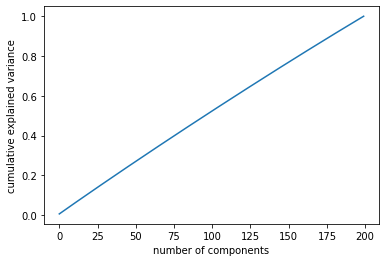

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()

X_train_PCA = pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


### Preprocessing

The first step we do is apply a *Standard normalization* to our features. Normalizing is needed to assign the same "importance" to each feature, and also it makes optimization algorithms faster.

We don't calculate features of polynomial order greater than $1$, since we already have $200$ features, and just calculating the features of second order would result in $200^2$ features

There are no features that have strong correlation with other features, and the Principal Component Analysis is not useful since all principal components explain the same amount of variance in the dataset. Therefore we do not remove any of the 200 fearues, and we don't do any transformation of our features with PCA

## 1.C

***Treat class labels as continuous and apply regression to the training data. Also,
calculate and report the posterior variance of the weights***

In [ ]:
sw2 = 1
K = 1
sn2 = 1

w_posterior_mean, w_posterior_cov = compute_posterior(X_train, y_train, sw2, sn2)  # @@ COMPLETE @@ #

In [ ]:
import tabulate
data = []

for i in range(w_posterior_cov.shape[0]):
    data.append([f"{i}", w_posterior_cov[i][i]])

headers = ["Weight n°","Posterior Variance"]
table = tabulate.tabulate(data, headers=headers, tablefmt="grid")
print(table)

+-------------+----------------------+
|   Weight n° |   Posterior Variance |
+=============+======================+
|           0 |          1.00252e-05 |
+-------------+----------------------+
|           1 |          1.00262e-05 |
+-------------+----------------------+
|           2 |          1.00265e-05 |
+-------------+----------------------+
|           3 |          1.00205e-05 |
+-------------+----------------------+
|           4 |          1.00204e-05 |
+-------------+----------------------+
|           5 |          1.00205e-05 |
+-------------+----------------------+
|           6 |          1.00263e-05 |
+-------------+----------------------+
|           7 |          1.00196e-05 |
+-------------+----------------------+
|           8 |          1.00206e-05 |
+-------------+----------------------+
|           9 |          1.00255e-05 |
+-------------+----------------------+
|          10 |          1.00184e-05 |
+-------------+----------------------+
|          11 |          

## 1.D

***Suggest a way to discretize predictions and display the confusion matrix on the
test data and report accuracy***

### Prediction discretization

Since we're using a regression model to do classification, our output needs to be discretized. A naive model could be to choose $0.5$ as the threshold, so 
\begin{cases}
0\text{ if } \hat{y}<0.5 \\ 
1\text{ otherwise }  
\end{cases}

However, using the ROC curve we can choose the best threshold, where with best we mean the one that gives the best ratio between *True positive rate* and *False positive rate*.

The threshold we obtain is 0.18, so our discretization will be
\begin{cases}
0\text{ if } \hat{y}<0.18 \\ 
1\text{ otherwise }  
\end{cases}

The accuracy we obtain is $0.79$
Below it's also displayed the confusion matrix normalized for *True label*

In [ ]:
def compute_predictive(Xt, w_mean, w_cov, sn2):
    def _compute_predictive_single_point(xt_i, w_mean, w_cov, sn2):
        yt_i_mean = xt_i.T @ w_mean # @@ COMPLETE @@ #
        yt_i_var = sn2 + xt_i.T @ w_cov @ xt_i # @@ COMPLETE @@ #
        
        return yt_i_mean, yt_i_var

    yt_mean, yt_var = np.zeros(len(Xt)), np.zeros(len(Xt))
    for i, xt_i in enumerate(Xt):  # Loop on all the points
        yt_mean[i], yt_var[i] = _compute_predictive_single_point(
            xt_i, w_mean, w_cov, sn2
        )

    return yt_mean, yt_var

In [ ]:
y_mean, y_var = compute_predictive(X_test, w_posterior_mean, w_posterior_cov, sn2)  # @@ COMPLETE @@ #

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_accuracy(y_test, y_pred):
  return accuracy_score(y_test, y_pred)


def plot_ROC_and_get_optimal_threshold(y_test, y_pred, method):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)

  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label=method)
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  # show the plot
  plt.show()

  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]

  return optimal_threshold

def plot_confusion_matrix(y_test, y_pred):

  conf_matrix = confusion_matrix(y_test, y_pred)

  s = sns.heatmap(conf_matrix/ (conf_matrix.sum(axis=1)[:, np.newaxis] ), annot=True, 
            fmt='.2%', cmap='Blues')

  s.set_xlabel('Predicted Label', fontsize=10)
  s.set_ylabel('True Label', fontsize=10)

  plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

def report_results(y_test, y_pred, method, standard_threshold=False):

  print(f"Results of {method}\n\n")

  optimal_threshold_LR = plot_ROC_and_get_optimal_threshold(y_test=y_test, y_pred=y_pred, method=method)

  threshold = 0.5 if standard_threshold else optimal_threshold_LR

  y_predictions = y_pred >= threshold

  accuracy = get_accuracy(y_test=y_test, y_pred=y_predictions)
  print(f"Accuracy: {accuracy}")
  print(f"Threshold: {threshold}")
  print(f"AUC score: {roc_auc_score(y_test, y_pred)}")
  print("\n\n")

  plot_confusion_matrix(y_test, y_predictions)

  print("\n\n")
  print("*"*40)

Results of Bayesian Linear Regression




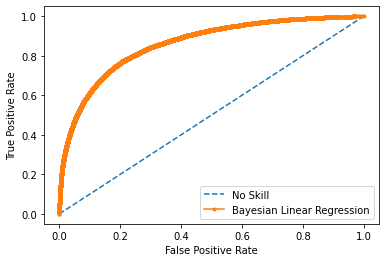

Accuracy: 0.79127
Threshold: 0.07558448678554551
AUC score: 0.8602067865055785





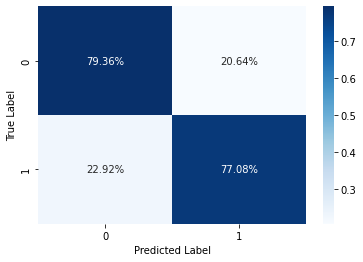




****************************************


In [ ]:
report_results(y_test=y_test, y_pred=y_mean, method="Bayesian Linear Regression")

# 2) Logistic Regression

## 2.A MH

***The goal is to implement a Bayesian logistic regression classifier; assume a
Gaussian prior on the parameters. As a first step, implement a Markov chain Monte Carlo inference algorithm to infer parameters (you should already have an implementation
of the Metropolis-Hastings algorithm from the lab sessions).***

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def logistic(z):
    return 1 / (1 + np.exp(-z)) # @@ COMPLETE @@ #

def bernoulli_density_sum_trick(y, p):

    zeros = np.zeros(p.shape)
    minus_p = -p

    a = np.maximum(0, minus_p)
    b = np.minimum(0, minus_p)

    log_sum = a + np.log( 1 + np.exp( b - a ) )

    likelihood = - y * log_sum + (1 - y) * (-p - log_sum)

    return likelihood


def gaussian_density(x, mean=0, var=1):
    return -0.5 * np.log(var*2*np.pi) - 0.5 * (x - mean)**2/var  # @@ COMPLETE @@ #

def logposterior(w, X, y, mean=0, var=1):
    # @@ COMPLETE @@ #

    log_likelihood = np.sum(bernoulli_density_sum_trick(y, X @ w))
    prior = np.sum(gaussian_density(w))
    
    log_post_un = log_likelihood + prior 

    return log_post_un # @@ COMPLETE @@ #

def rw_mh_step(w_prev, X, y, step_size):
    # @@ COMPLETE @@ #

    # step size: standard deviation della proposal distribution
    w_s = np.random.multivariate_normal(w_prev, (step_size) * np.eye(len(w_prev)))

    r = np.exp(logposterior(w_s, X, y) - logposterior(w_prev, X, y))
    
    if r >= 1:
      return w_s

    u = np.random.uniform(0,1)

    if u <= r:
      return w_s

    return w_prev

def run_sampling(w, X, y, n_samples, step_size=1):
    w = np.atleast_1d(w)
    samples = np.empty((n_samples, *w.shape))
    for i in tqdm(range(n_samples), desc="Metropolis Hastings"):
        w = rw_mh_step(w, X, y, step_size)
        samples[i] = w
    return samples

In [ ]:
def run_MH(X, y, n_samples=10000, step_size=1e-3):

  number_features = X.shape[1]
  w_init = np.random.rand(number_features)

  # Metropolis-Hastings algorithm
  samples = run_sampling(w_init, X, y, n_samples=n_samples, step_size=step_size)  # @@ COMPLETE @@ #

  return samples


In [ ]:
import matplotlib.pyplot as plt

def plot_traces(samples):
  fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=[12, 6], sharex=True)

  ax0.plot(list(range(0, samples.shape[0])), samples[:, 0] )
  ax1.plot(list(range(0, samples.shape[0])), samples[:, 1] )
  ax2.plot(list(range(0, samples.shape[0])), samples[:, 2] )
  ax3.plot(list(range(0, samples.shape[0])), samples[:, 3] )
  ax4.plot(list(range(0, samples.shape[0])), samples[:, 40] )



  ax0.set_ylabel(r"$w_0$")
  ax1.set_ylabel(r"$w_1$")
  ax2.set_ylabel(r"$w_2$")
  ax3.set_ylabel(r"$w_3$")
  ax4.set_ylabel(r"$w_4$")


  ax0.set_title("Trace plot")
  ax1.set_xlabel(r"Sample index")


  plt.show()


In [ ]:
samples = run_MH(X_train, y_train, n_samples=10000, step_size=1e-3)

Metropolis Hastings:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp


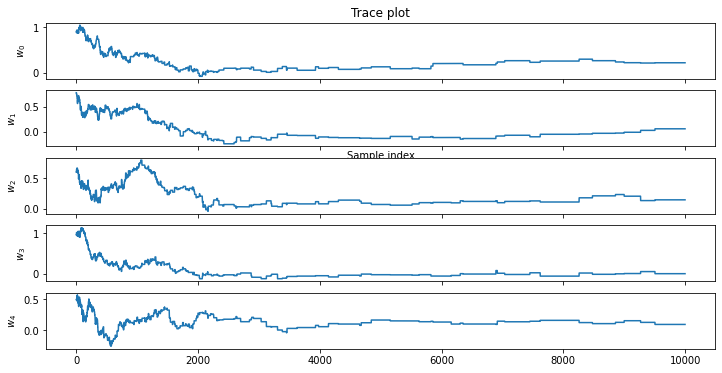

In [ ]:
plot_traces(samples)

In [ ]:
# Burn-in
samples = samples[4000:, :]

In [ ]:
def predict_MH(Xt, samples):
    S = len(samples)

    summary = 0
    for i in tqdm(range(S), desc="Prediction Metropolis Hastings"):
      summary += logistic(Xt @ samples[i])

    return (1/S) * summary  # @@ COMPLETE @@ #


y_pred_MH = predict_MH(X_test, samples)

Prediction Metropolis Hastings:   0%|          | 0/6000 [00:00<?, ?it/s]

In [ ]:
y_pred_MH

array([0.26067501, 0.58461816, 0.22655179, ..., 0.74312026, 0.26953292,
       0.61703473])

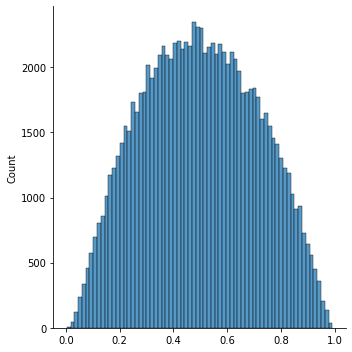

In [ ]:
# Plot distribution of predictions (y_hat)

import seaborn as sns 
sns.displot(y_pred_MH)

## 2.B Variational approximation

***Implement the variational approximation we studied in the course to obtain an
approximation to the posterior over model parameters (you should already have an implementation of the from the lab sessions)***

In [ ]:
import jax
import jax.numpy as jnp
from functools import partial
from typing import NamedTuple
from tqdm.notebook import tqdm


class GaussianDiagonal(NamedTuple):
    mean: jnp.array
    log_var: jnp.array


def bernoulli_density_sum_trick(y, p):

    zeros = jnp.zeros(p.shape)
    minus_p = -p

    a = jnp.maximum(0, minus_p)
    b = jnp.minimum(0, minus_p)

    log_sum = a + jnp.log( 1 + jnp.exp( b - a ) )

    likelihood = - y * log_sum + (1 - y) * (-p - log_sum)

    return likelihood


def sample_gaussian_diagonal(rng, params):
    mean, log_var = params
    eps = jax.random.normal(key=rng, shape=mean.shape) # @@ COMPLETE @@ #

    return mean + eps * jax.numpy.exp(log_var)  # @@ COMPLETE @@ #

def kl_diag_diag(q_params, p_params):
    assert isinstance(q_params, GaussianDiagonal)
    assert isinstance(p_params, GaussianDiagonal)
    mean_q, log_var_q = q_params
    mean_p, log_var_p = p_params

    # @@ COMPLETE @@ #
    var_q = jax.numpy.exp(log_var_q)
    var_p = jax.numpy.exp(log_var_p)

    kl = (1/2) * jax.numpy.sum(log_var_p - log_var_q + (var_q + jax.numpy.square(mean_q - mean_p))/(var_p) - 1)
    # kl = (1/2) * jax.numpy.sum(jnp.log(var_p/var_q) + (var_q + jax.numpy.square(mean_q - mean_p))/(var_p) - 1)

    return kl

def logistic(z):
    return 1 / (1 + jax.numpy.exp(-z)) # @@ COMPLETE @@ #


def model(w, X):
    return logistic(X @ w) # @@ COMPLETE @@ #

In [ ]:
def create_elbo_fn(sample_fn, likelihood_fn, kl_divergence_fn):
    """Create a function to compute the ELBO, given the function to sample
    from the posterior, the likelihood function and the KL divergence
    """

    @partial(jax.vmap, in_axes=[0, None, None, None])
    def likelihood_sample_fn(rng, q_params, X, y):
        """Compute the likelihood with one Monte Carlo sample of the posterior
        The function is decorated to vectorize multiple MC samples automatically
        """
        # Get one sample of w using the sample_fn and the parameters of q
        w = sample_fn(rng=rng, params=q_params) # @@ COMPLETE @@ #
        p = X @ w

        likelihood = likelihood_fn(y, p)

        return likelihood # @@ COMPLETE @@ #

    def elbo_fn(q_params, p_params, rng, X, y, Nmc=1):
        """Computes the ELBO with multiple samples"""
        # Split the random seed in Nmc times
        rng = jax.random.split(rng, Nmc)

        # Compute the values of the likelihood
        likelihood_vals = likelihood_sample_fn(rng, q_params, X, y) # @@ COMPLETE @@ #


        likelihood_vals = jnp.sum(likelihood_vals, axis=1)

        # Compute the expectation (i.e. take the mean)
        expected_likelihood = jnp.mean(likelihood_vals) # @@ COMPLETE @@ #
        # Compute the KL divergence
        kl = kl_divergence_fn(q_params, p_params)# @@ COMPLETE @@ #
        # Compute the ELBO
        elbo = expected_likelihood - kl # @@ COMPLETE @@ #
        # Return the ELBO and its two term (used later for logging)
        return elbo, (expected_likelihood, kl)

    return elbo_fn


In [ ]:
elbo_fn = create_elbo_fn(
    sample_fn=sample_gaussian_diagonal,# @@ COMPLETE @@ #
    kl_divergence_fn=kl_diag_diag,# @@ COMPLETE @@ #
    likelihood_fn=bernoulli_density_sum_trick# @@ COMPLETE @@ #
)

In [ ]:
def initialize_params(X_train):

  number_of_features = X_train.shape[1]

  p_params = GaussianDiagonal(jnp.zeros(number_of_features), jnp.zeros(number_of_features))  # @@ COMPLETE @@ #
  q_params = GaussianDiagonal(jnp.zeros(number_of_features), jnp.zeros(number_of_features))

  return p_params, q_params

In [ ]:
def sg_update(params, gradients, learning_rate=1e-3):
    updated_params = jax.tree_map(lambda p, g: p + learning_rate * g, params, gradients)
    return updated_params
    
grad_elbo_fn = jax.grad(elbo_fn, has_aux=True)
grad_elbo_fn = jax.jit(grad_elbo_fn, static_argnames=("Nmc"))

In [ ]:
import math

def run_variational_inference(q_params, p_params, X_train, y_train, grad_elbo_fn, Nmc=100, learning_rate=1e-4, n_iterations=10000):

  rng = jax.random.PRNGKey(0)

  elbo_summary = []
  lik_summary = []
  kl_summary = []

  for i in tqdm(range(n_iterations), desc="Training ELBO"):
    rng, rng2 = jax.random.split(rng)

    if any([math.isnan(x) for x in q_params.mean]):
      print(f"NULL: {i}")


    q_params_grad, (likelihood, kl) = grad_elbo_fn(q_params, p_params, rng, X_train, y_train, Nmc=Nmc) # @@ COMPLETE @@ #

    q_params = sg_update(q_params, q_params_grad, learning_rate=learning_rate) # @@ COMPLETE @@ #

    lik_summary.append(likelihood)
    kl_summary.append(kl)
    elbo_summary.append(likelihood - kl)

  return q_params, elbo_summary, lik_summary, kl_summary


In [ ]:
p_params, q_params = initialize_params(X_train)
q_params, elbo_summary, lik_summary, kl_summary = run_variational_inference(q_params, p_params, X_train, y_train, grad_elbo_fn, Nmc=100, learning_rate=1e-4, n_iterations=10000)

Training ELBO:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print("Converged posterior")
print("Mean =", q_params.mean)
print("Var =", np.exp(q_params.log_var))

Converged posterior
Mean = [ 1.65005922e-02  8.14791918e-02  6.82042912e-02  1.30669743e-01
 -1.14971325e-01  5.38772345e-03  2.35722959e-03 -1.14770606e-02
  1.81426182e-01 -9.35750008e-02 -9.01219472e-02 -1.16464198e-02
 -1.29394442e-01  4.07464206e-02 -5.25965318e-02  7.21775293e-02
  4.05536778e-02 -1.30936027e-01  1.34666726e-01  6.43196106e-02
 -8.32333863e-02 -8.25607255e-02  1.82561830e-01  1.04804710e-03
 -3.32358181e-02  9.57443006e-03  8.70938152e-02  7.17534721e-02
 -1.33526683e-01  3.47811207e-02  1.02698594e-01 -5.39846756e-02
  5.75823188e-02 -1.37036636e-01 -1.84172332e-01  4.93413992e-02
 -1.18353568e-01 -5.96347824e-03 -2.94487067e-02 -2.01875693e-03
 -1.12614065e-01 -1.62410036e-01 -1.45608500e-01  1.52674317e-02
 -5.98026104e-02  7.56611824e-02  1.45705089e-01 -2.59543881e-02
  6.79427087e-02  7.00712875e-02 -3.36483121e-04 -5.68168759e-02
 -1.72541961e-02  9.35666263e-03  9.95233655e-03 -5.85979372e-02
 -2.85383165e-02  3.03436816e-02 -1.19291872e-01 -1.63929895e-0

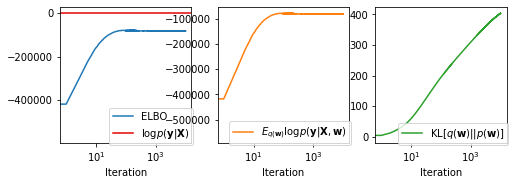

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=[8, 2.5])

ax0.plot(elbo_summary, label="ELBO")
ax1.plot(
    lik_summary,
    color="tab:orange",
    label=r"$E_{q(\mathbf{w})} \log p(\mathbf{y}|\mathbf{X},\mathbf{w})$",
)
ax2.plot(
    kl_summary,
    color="tab:green",
    label=r"$\mathrm{KL}[{q(\mathbf{w})}||{p(\mathbf{w})}]$",
)

ax0.semilogx()
ax1.semilogx()
ax2.semilogx()

ax0.axhline(-0.4, color="xkcd:red", label=r"$\log p(\mathbf{y}|\mathbf{X})$")
ax0.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax1.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax2.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")

ax0.set_xlabel("Iteration")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Iteration")

plt.show()

## 2.C

***Based on samples from the posterior over model parameters, write a function
that computes the predictive distribution, and write the necessary functions to evaluate classification metrics such as the log-likelihood on test data and error rate.***

In [ ]:
def predict_y(sample_fn, q_params, Xt, Nmc=10):
    """Compute the outputs of the model by sampling the posterior,
    then take the expectation
    """

    rng = jax.random.PRNGKey(0)

    def predict_y_single(rng):
        w = sample_fn(rng=rng, params=q_params) # @@ COMPLETE @@ #
        yp = model(w, Xt) # @@ COMPLETE @@ #
        return yp

    rng = jax.random.split(rng, Nmc)
    Xt = jnp.atleast_1d(Xt)
    yp = jax.vmap(predict_y_single)(rng)
    # Take the mean
    print(yp.shape)
    yp = jax.numpy.mean(yp, axis=0) # @@ COMPLETE @@ #
    return yp


y_pred_VA = predict_y(sample_gaussian_diagonal, q_params, X_test, Nmc=1000)

(1000, 100000)


In [ ]:
def logistic_loglik(y, y_tilde):

    N = len(y)
    return (1/N) * np.sum(y * np.log(y_tilde) + (1 - y)* np.log((1 - y_tilde)))

In [ ]:
def error_rate(y, y_pred):
  """
  Count the number of errors w.r.t the total number of predictions
  error rate = 1 - accuracy
  """

  assert(len(y) == len(y_pred))
  return (y != y_pred).sum() / len(y)

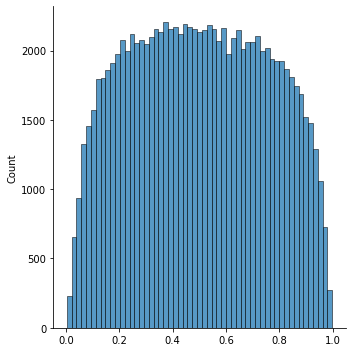

In [ ]:
# plot the distribution of prediction of Variational Inference (y_hat)

import seaborn as sns 
sns.displot(y_pred_VA)

## 2.D

**Comment on the tuning of the Metropolis-Hastings algorithm, and how to guarantee that samples are representative of samples of the posterior over model parameters.**

In Metropolis-Hastings we calculate the acceptance ratio using the log-posterior. This can create NaN/infinite values of the acceptance ratio due to the exponential inside the logarithm present in the log-likelihood.

\begin{align}
    \log p(y_i| w, x_i) = -y_i \log(1 + e^{-w^Tx_i}) - (1 - y_i)\log(1 + e^{w^Tx_i})
\end{align}

To solve this issue we implemented the log sum trick ( Assume $a > b$ )
\begin{align}
    \log(e^{a} + e^b) = \log(e^{a}(1 + \frac{e^b}{e^a})) = a + \log(1 + e^{b-a})
\end{align}

We tried different step sizes ([1e-3, 1e-4, 1e-5]), the one that performed better and that got more stable results was $10^{-3}$.


We initially picked a number of samples obtained in the random walk equal to $10000$.
Looking at the plot of the first 5 components of our samples, it seems that after the first $4000$ samples we reach the equilibrium distribution. Therefore we apply the burn-in, removing the first $4000$ samples to get representative samples


## 2.E

**Comment on the tuning of the variational inference algorithm, and discuss the be-
havior of the optimization with respect to the choice of the optimizer/step-size.**

The variational inference algorithm tries to minimize the ELBO, which is composed by the expected log-likelihood and the KL between the prior distribution and the distribution approximation

\begin{align}
\mathcal{L}(\theta) = \underbrace{\mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w})}_\text{Expected loglikelihood} -\mathrm{KL}[{q_{\theta}(\boldsymbol{w})}||{p(\boldsymbol{w})}]
\end{align}

The loglikelihhod, as in the Metropolis Hastings algoritmh, is sensible to the problem of NaN/infinite values, due to the logaritmhs of exponentials.
As before, we apply the log sum trick to help solving the problem. 

We also use only small learning rates, not to make "jumps" too big, especially in the first iterations, where the KL distance between the approximation and the likelihood is probably high. 

A better initialization of the parameters could also tackle the problem.

The other hyperparameters are *Nmc* (number of MonteCarlo samples used to compute the expected likelihood) and *n_iterations* (number of iterations of the *ELBO* algorithm)

We tried:
*   *Nmc* = [10, 100, 1000]
*   *n_iterations* = [1000, 10000]
*   *lr* : [1e-3, 1e-4]

We achieved better performances with Nmc = 100, n_iterations = 100000 and lr = 1e-4

The optimizer used is SGD with no momentum

## 2.F

Results of Metropolis Hastings




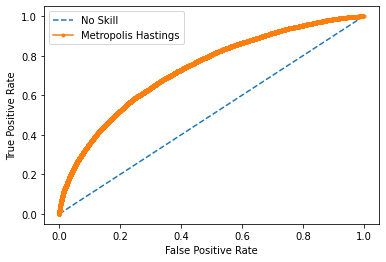

Accuracy: 0.67244
Threshold: 0.586085829272262
AUC score: 0.7331247076164953





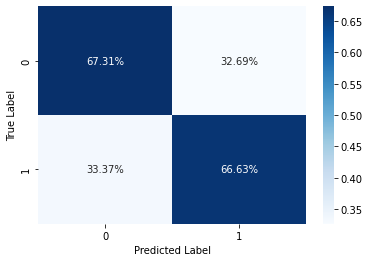




****************************************


In [ ]:
report_results(y_test=y_test, y_pred=y_pred_MH, method="Metropolis Hastings", standard_threshold=False)

Results of Variational Inference




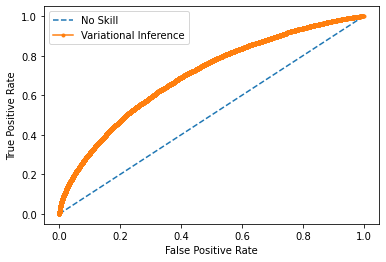

Accuracy: 0.66878
Threshold: 0.619857668876648
AUC score: 0.701979370823606





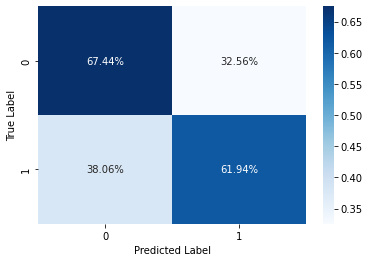




****************************************


In [ ]:
report_results(y_test=y_test, y_pred=y_pred_VA, method="Variational Inference", standard_threshold=False)

## 2.G

In [ ]:
def neg_logistic_loglik(y, y_tilde):

    # SUM[ yi log p(xi)+ (1 − yi)log(1 − p(xi)) ]

    N = len(y)

    return -(1/N) * np.sum(y * np.log(y_tilde) + (1 - y)* np.log((1 - y_tilde)))
  

In [ ]:
print(f"Negative log-likelihood of Metropolis Hastings: {neg_logistic_loglik(y=y_test, y_tilde=y_pred_MH):.2f}")
print(f"Negative log-likelihood of Variational Inference: {neg_logistic_loglik(y=y_test, y_tilde=y_pred_VA):.2f}")

Negative log-likelihood of Metropolis Hastings: 0.73
Negative log-likelihood of Variational Inference: 0.80


The Metropolis Hastings has an higher log-likelihood

Now we pick prediction of Metropolis-Hastings around 0.5:

In [ ]:
mask = (y_pred_MH >= 0.49) & (y_pred_MH <= 0.51)
y_pred_MH_around_05 = y_pred_MH[mask]

y_test_masked = y_test[mask]

y_predictions_MH = y_pred_MH > 0.5

indices_of_correct_pred = np.where((y_predictions_MH[mask] == y_test[mask]))[0][:10]
indices_of_wrong_pred = np.where((y_predictions_MH[mask] != y_test[mask]))[0][:10]


In [ ]:
print(f"Values of correct predictions: {y_pred_MH_around_05[indices_of_correct_pred]}")
print(f"Values of wrong predictions: {y_pred_MH_around_05[indices_of_wrong_pred]}")

Values of correct predictions: [0.49254644 0.49192418 0.5065492  0.49283613 0.4910725  0.49864654
 0.49536422 0.49249286 0.49683118 0.49598312]
Values of wrong predictions: [0.50541836 0.50982128 0.504224   0.50738872 0.50029494 0.50684825
 0.50995714 0.49407289 0.50868136 0.50419831]


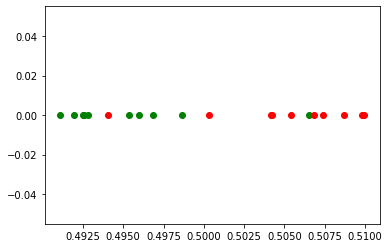

In [ ]:
plt.plot(y_pred_MH_around_05[indices_of_correct_pred], np.zeros_like(y_pred_MH_around_05[indices_of_correct_pred]), 'go')
plt.plot(y_pred_MH_around_05[indices_of_wrong_pred], np.zeros_like(y_pred_MH_around_05[indices_of_wrong_pred]), 'ro')

plt.show()

Most of the data wrongly classified are above the threshold of 0.5. This is due to the fact that our dataset is imbalanced.



# 3 (BONUS)

## 3.A Laplace approximation

$$ S^{-1}_N = - \nabla \nabla log \ p(w | X, y) $$
$$ \log p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y}) \propto \log p(\boldsymbol{y}|\boldsymbol{w}, \boldsymbol{X}) + \log p(\boldsymbol{w}) $$

Source derivative of log likelihood: https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d

$$ \nabla log \ p(w_t | X, y) = X^T(\hat{y} - y) - {\Sigma}_{w_{t-1}}^{-1}(w_t - w_{t-1}^{-1})$$
$$ H = \nabla \nabla log \ p(w_t | X, y) = X^T (- \hat{y}(1 - \hat{y}))X - {\Sigma}_{w_{t-1}}^{-1}$$

In [ ]:
def gaussian_density(x, mean, var):

    var = np.diag(var)
    return -0.5 * np.log(var*2*np.pi) - 0.5 * (x - mean)**2/var  # @@ COMPLETE @@ #


def logposterior(w, X, y, mean, var):
    # @@ COMPLETE @@ #

    # print(w)

    log_likelihood = np.sum(bernoulli_density_sum_trick(y, X @ w))
    prior = np.sum(gaussian_density(w, mean, var))
    
    log_post_un = log_likelihood + prior 

    return log_post_un # @@ COMPLETE @@ #

def logposterior_grad(w, X, y, prior_mean, prior_cov):
    y_hat = logistic(X @ w)
    
    return X.T @ (y_hat - y) - np.linalg.inv(prior_cov) @ (w - prior_mean)


def logposterior_hessian(w, X, y, prior_mean, prior_cov):
    y_hat = logistic(X @ w)
    
    return (X.T * (-y_hat * (1 - y_hat))) @ X - np.linalg.inv(prior_cov)

In [ ]:
from scipy.optimize import least_squares

def laplace_approx(X, y, w_init, prior_mean, prior_cov):

    # As an optimization method to find the posterior mean I use the Trust Region Reflective algorithm
    # Source: https://it.mathworks.com/help/optim/ug/equation-solving-algorithms.html
    posterior_mean = least_squares(logposterior, x0=w_init, args=[X_train, y_train, prior_mean, prior_cov], verbose=2).x
    
    hess = logposterior_hessian(posterior_mean, X, y, prior_mean, prior_cov)
    posterior_var = np.linalg.inv(-hess)

    return posterior_mean, posterior_var
    

In [ ]:
number_of_featues = X_train.shape[1]
prior_cov = np.eye(number_of_featues)
prior_mean = np.zeros(number_of_featues)
w_init = np.random.normal(loc=0, scale=1e-2, size=number_of_featues)


w_map, s_n = laplace_approx(X_train, y_train, w_init, prior_mean, prior_cov)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4457e+09                                    1.93e+08    
       1              2         2.3164e+09      1.29e+08       1.48e-01       1.33e+08    
       2              3         2.1938e+09      1.23e+08       2.97e-01       2.86e+07    
       3              5         2.1880e+09      5.77e+06       7.42e-02       4.06e+06    
       4              7         2.1880e+09      7.16e+04       1.85e-02       2.28e+06    
       5              8         2.1879e+09      3.20e+04       4.64e-03       7.34e+05    
       6             10         2.1879e+09      2.81e+03       1.16e-03       3.41e+05    
       7             11         2.1879e+09      7.42e+02       1.16e-03       5.34e+04    
       8             13         2.1879e+09      1.00e+01       2.90e-04       3.80e+04    
       9             14         2.1879e+09      1.00e+01       7.24e-05       1.61e+04    

In [ ]:
samples = np.random.multivariate_normal(w_map, s_n, 1000)

y_pred_LA = predict_MH(X_test, samples)

Prediction Metropolis Hastings:   0%|          | 0/1000 [00:00<?, ?it/s]

Results of Laplace




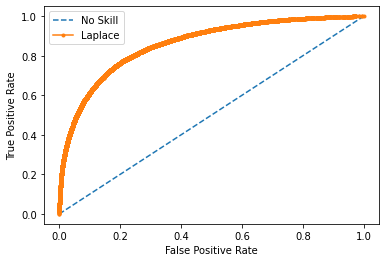

Accuracy: 0.79014
Threshold: 0.5798185371253234
AUC score: 0.8602090466072659





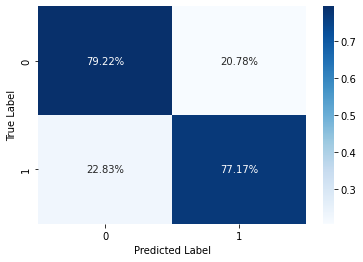




****************************************


In [ ]:
report_results(y_test=y_test, y_pred=y_pred_LA, method="Laplace", standard_threshold=False)

## 3.B Other implementations

The main problem of the dataset is the imbalance of the data. We could try solving it in different methods other than threshold moving:
*   Resampling: resample many times from the sample belonging to the minority class
*   Undersampling: pick only an handful of the sample belonging to the majority class to rebalance the distributions
*   SMOTE: create synthetic data starting from the data of the minority class

Other than this, we could try different optimization methods in the Variational Inference methods.
